In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.gridspec import GridSpec
from plot import get_model_style, MODEL_FAMILIES
from data import make_metrics_cumulative, filter_runs, pad_to_max_length

In [3]:
full_df = pd.read_pickle("/ceph/ssd/staff/beyer/llm-quick-check/outputs/attack_runs_latest.pkl")

In [4]:
# Define a function to compute accuracy
def compute_agreement(row):
    v = np.array(row["asr_cais"])
    v2 = np.array(row["asr_llama_guard_3_8b"])
    # Check for None or NaN values
    if None in v or None in v2 or np.isnan(v).any() or np.isnan(v2).any():
        return None
    return (v == v2).mean()

def compute_asr_total(row):
    v = np.array(row["asr_cais"])
    v2 = np.array(row["asr_llama_guard_3_8b"])
    # Check for None or NaN values
    if None in v or np.isnan(v).any():
        return v.tolist()
    if None in v2 or np.isnan(v2).any():
        return v2.tolist()
    return np.logical_and(v, v2).tolist()

def compute_cais_avg(row):
    v = np.array(row["asr_cais"])
    v2 = np.array(row["asr_llama_guard_3_8b"])
    # Check for None or NaN values
    if None in v or None in v2 or np.isnan(v).any() or np.isnan(v2).any():
        return None
    return v.mean()

def compute_llama_avg(row):
    v = np.array(row["asr_cais"])
    v2 = np.array(row["asr_llama_guard_3_8b"])
    # Check for None or NaN values
    if None in v or None in v2 or np.isnan(v).any() or np.isnan(v2).any():
        return None
    return v2.mean()
# Apply the function to the DataFrame and create a new column
full_df["agreement"] = full_df.apply(compute_agreement, axis=1)
full_df["asr_total"] = full_df.apply(compute_asr_total, axis=1)
full_df["cais_avg"] = full_df.apply(compute_cais_avg, axis=1)
full_df["llama_avg"] = full_df.apply(compute_llama_avg, axis=1)

Text(0.5, 1.0, 'Agreement between CAIS and LlamaGuard (mean: 0.76)')

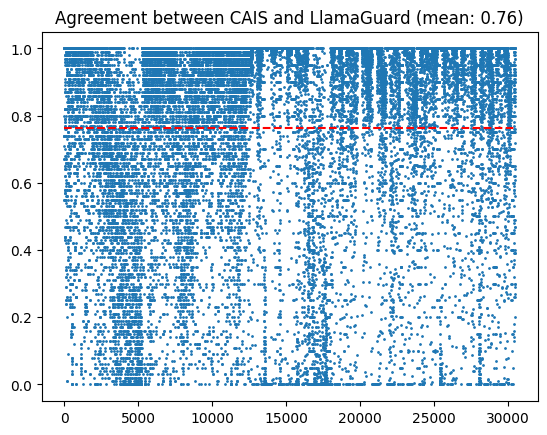

In [5]:
#  Plot the accuracy values
plt.scatter(full_df.index, full_df["agreement"], s=1)
mean_corr = full_df["agreement"].dropna().mean()

plt.hlines(mean_corr, 0, len(full_df), colors='r', linestyles='dashed')
plt.title(f"Agreement between CAIS and LlamaGuard (mean: {mean_corr:.2f})")

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cais = []
llama = []
for _, row in full_df.iterrows():
    if None in row["asr_cais"] or None in row["asr_llama_guard_3_8b"]:
        continue
    cais.extend(row["asr_cais"])
    llama.extend(row["asr_llama_guard_3_8b"])
# Compute the confusion matrix
cm = confusion_matrix(cais, llama)
# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('LlamaGuard')
plt.ylabel('CAIS')
plt.title('Confusion Matrix between CAIS and LlamaGuard')
plt.show()


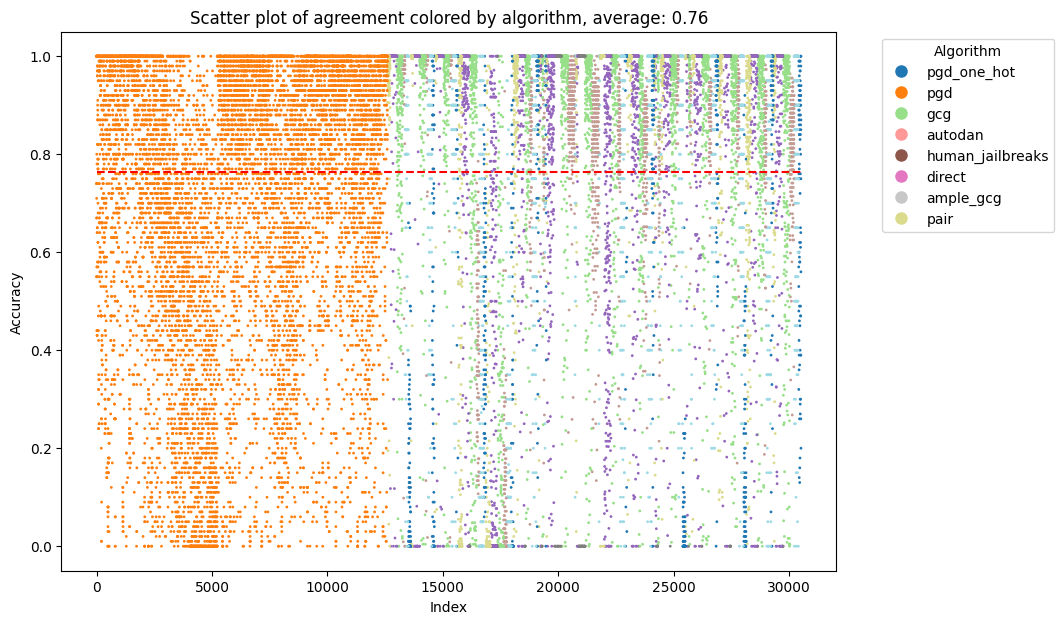

In [25]:
color_by = "algorithm"
# color_by = "model"

# Get unique algorithms and map them to integers
unique_algorithms = full_df[color_by].unique()
algorithm_to_color = {alg: i for i, alg in enumerate(unique_algorithms)}

# Map the algorithm column to corresponding numeric values
colors = full_df[color_by].map(algorithm_to_color)

# Define a colormap for the categorical data
cmap = plt.cm.tab20  # Or another categorical colormap like 'Set1', 'Paired'

# Create the scatter plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(full_df.index, full_df["agreement"], c=colors, cmap=cmap, s=1)
plt.hlines(mean_corr, 0, len(full_df), colors='r', linestyles='dashed')


# Create a custom legend
handles = [plt.Line2D([0], [0], marker='o', color=cmap(i / len(unique_algorithms)),
                      markersize=8, linestyle='', label=alg)
           for i, alg in enumerate(unique_algorithms)]
plt.legend(handles=handles, title="Algorithm", bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Accuracy')
plt.title(f'Scatter plot of agreement colored by {color_by}, average: {mean_corr:.2f}')

plt.show()

(-0.85, 7.5)

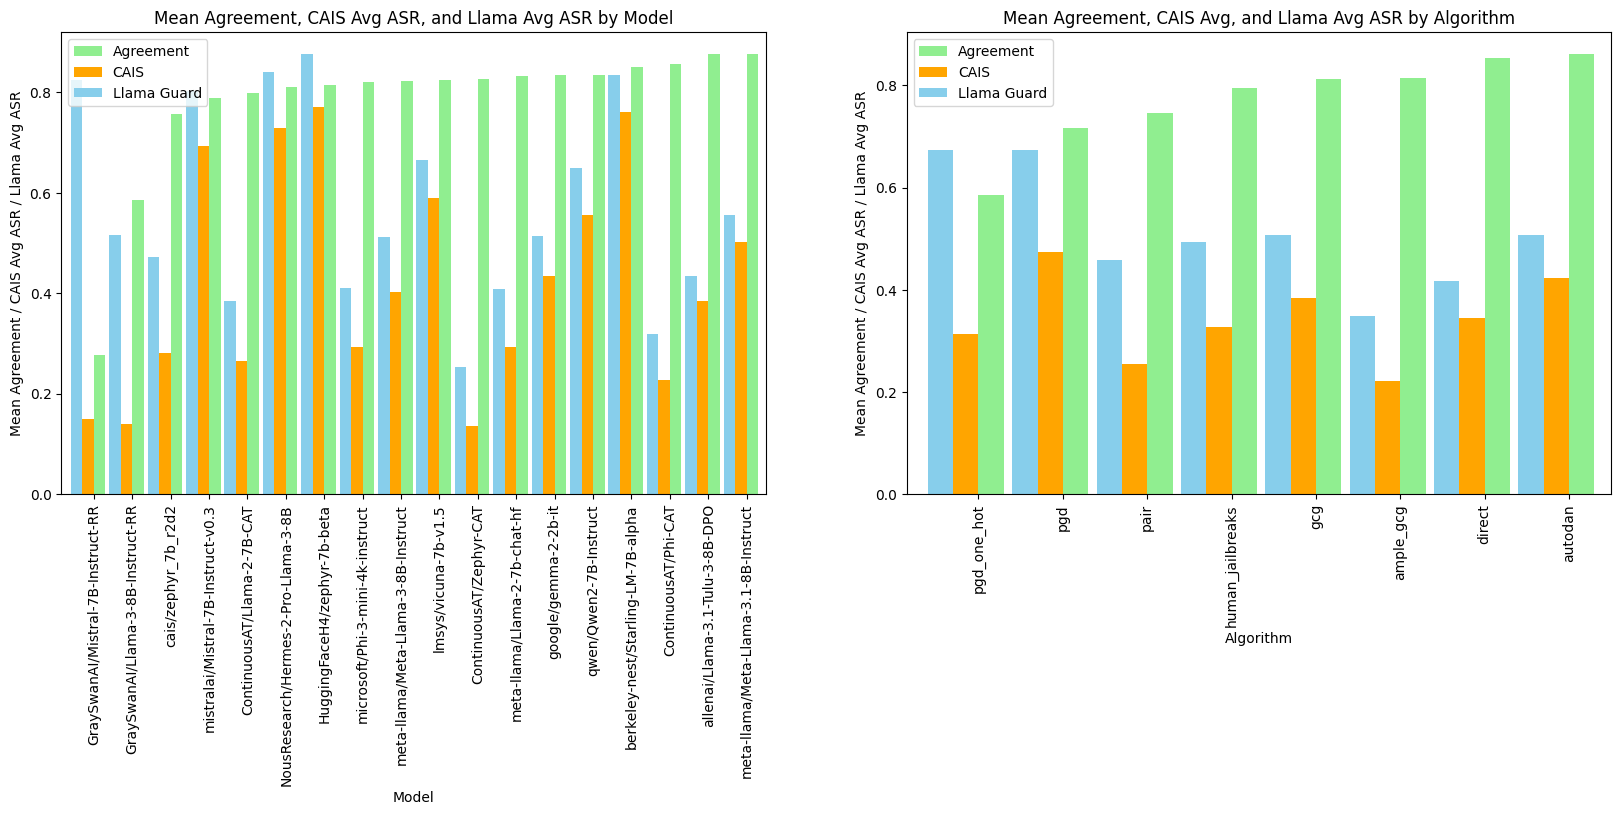

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Create a bar plot for mean agreement by model
mean_by_model = full_df.groupby('model')['agreement'].mean().sort_values()
mean_by_model_cais = full_df.groupby('model')['cais_avg'].mean().reindex(mean_by_model.index)
mean_by_model_llama = full_df.groupby('model')['llama_avg'].mean().reindex(mean_by_model.index)
mean_by_model.plot(kind='bar', color='lightgreen', ax=axes[0], position=0, width=0.3)
mean_by_model_cais.plot(kind='bar', color='orange', ax=axes[0], position=1, width=0.3)
mean_by_model_llama.plot(kind='bar', color='skyblue', ax=axes[0], position=2, width=0.3)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Mean Agreement / CAIS Avg ASR / Llama Avg ASR')
axes[0].set_title('Mean Agreement, CAIS Avg ASR, and Llama Avg ASR by Model')
axes[0].tick_params(axis='x', rotation=90)
axes[0].legend(['Agreement', 'CAIS', 'Llama Guard'])

# Create a bar plot for mean agreement by algorithm
mean_by_algorithm = full_df.groupby('algorithm')['agreement'].mean().sort_values()
mean_by_algorithm_cais = full_df.groupby('algorithm')['cais_avg'].mean().reindex(mean_by_algorithm.index)
mean_by_algorithm_llama = full_df.groupby('algorithm')['llama_avg'].mean().reindex(mean_by_algorithm.index)
mean_by_algorithm.plot(kind='bar', color='lightgreen', ax=axes[1], position=0, width=0.3)
mean_by_algorithm_cais.plot(kind='bar', color='orange', ax=axes[1], position=1, width=0.3)
mean_by_algorithm_llama.plot(kind='bar', color='skyblue', ax=axes[1], position=2, width=0.3)
axes[1].set_xlabel('Algorithm')
axes[1].set_ylabel('Mean Agreement / CAIS Avg ASR / Llama Avg ASR')
axes[1].set_title('Mean Agreement, CAIS Avg, and Llama Avg ASR by Algorithm')
axes[1].tick_params(axis='x', rotation=90)
axes[1].legend(['Agreement', 'CAIS', 'Llama Guard'])

axes[0].set_xlim(axes[0].get_xlim()[0], axes[0].get_xlim()[1] + 0.5)
axes[1].set_xlim(axes[1].get_xlim()[0], axes[1].get_xlim()[1] + 0.5)

In [8]:
N_PROMPTS = 40
df = full_df[full_df['prompt_idx'] < N_PROMPTS]
# Filter out runs that we care about
model_family = 'llama3'
models = MODEL_FAMILIES[model_family]['ids']
target_df = df[df['model'].isin(models)]

In [9]:
target_df[(target_df['algorithm'] == 'pgd') & (target_df["prompt_idx"] == 0) & (target_df["model"] == "NousResearch/Hermes-2-Pro-Llama-3-8B")]["algorithm_params"].values

array(['{"alpha": 0.001, "batch_size": 16, "embedding_scale": 0.59375, "epsilon": 0.1, "generate_completions": "all", "max_new_tokens": 256, "name": "pgd", "normalize_alpha": true, "num_steps": 100, "optim_str_init": "x x x x x x x x x x x x x x x x x x x x", "placement": "suffix", "seed": 0, "type": "continuous"}',
       '{"alpha": 0.001, "batch_size": 16, "embedding_scale": 0.59375, "epsilon": 0.1, "generate_completions": "all", "max_new_tokens": 256, "name": "pgd", "normalize_alpha": true, "num_steps": 100, "optim_str_init": "", "placement": "command", "seed": 0, "type": "continuous"}',
       '{"alpha": 0.001, "batch_size": 16, "embedding_scale": 0.59375, "epsilon": 0.1, "generate_completions": "all", "max_new_tokens": 256, "name": "pgd", "normalize_alpha": false, "num_steps": 100, "optim_str_init": "x x x x x x x x x x x x x x x x x x x x", "placement": "suffix", "seed": 0, "type": "continuous"}',
       '{"alpha": 0.001, "batch_size": 16, "embedding_scale": 0.59375, "epsilon": 1

In [10]:
# Filter the dataframe for the 'pgd' algorithm
def plot_per_model_average_metric(
    df: pd.DataFrame,
    algorithm: str,
    metric: str,
    algorithm_params: dict = None,
):
    """
    Filters the DataFrame, computes per-model average metric, and plots the result.

    Args:
        df (pd.DataFrame): The input DataFrame containing runs data.
        algorithm (str): The algorithm to filter for.
        metric (str): The metric to compute averages for.
        algorithm_params (dict, optional): Parameters to filter runs by. Defaults to None.
        title_suffix (str, optional): Additional text to append to the plot title.
    """
    # Filter runs based on algorithm and optional parameters
    attack_df = filter_runs(df, algorithm=algorithm, algorithm_params=algorithm_params)

    print(f"Found {len(attack_df)} {algorithm} runs")

    # Pad metrics to maximum length and make cumulative
    attack_df = pad_to_max_length(attack_df)
    attack_df = make_metrics_cumulative(attack_df)

    # Merge runs of the same model and prompt_idx by averaging to avoid over-sampling
    # prompts with multiple runs
    merged_df = (
        attack_df.groupby(['model', 'prompt_idx'])[metric]
        .apply(lambda x: np.mean(np.stack(x), axis=0))
        .reset_index()
    )
    print(f"Merging into {len(merged_df)} runs")
    # Group by model and calculate the average metric per step
    grouped_models = merged_df.groupby('model')
    model_avg_metric = {}

    for model, group in grouped_models:
        # Combine all metric lists across rows for this model
        combined_metrics = np.array([item for metric_list in group[metric] for item in metric_list]).reshape(-1, len(group[metric].iloc[0]))
        # Compute per-step averages
        mean_per_step = combined_metrics.mean(axis=0)
        model_avg_metric[model] = mean_per_step

    # Plot the average metric curves for each model
    plt.figure(figsize=(10, 6))
    for model, avg_metric in model_avg_metric.items():
        plt.plot(range(1, len(avg_metric) + 1), avg_metric, marker='o', linestyle='-', label=f'Model: {model}')

    # Add labels, title, and legend
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric}')
    title = f'Per-Model Average {metric} for {algorithm} opt: {algorithm_params}'
    plt.title(title)
    plt.legend()
    if metric == "loss":
        plt.yscale('log')
    else:
        plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

def plot_attacks_per_model(
    df: pd.DataFrame,
    algorithms: str | list[str],
    metric: str,
    algorithm_params: dict = None,
):
    """
    Filters the DataFrame, computes per-model average metric, and plots the result.

    Args:
        df (pd.DataFrame): The input DataFrame containing runs data.
        algorithm (str): The algorithm to filter for.
        metric (str): The metric to compute averages for.
        algorithm_params (dict, optional): Parameters to filter runs by. Defaults to None.
        title_suffix (str, optional): Additional text to append to the plot title.
    """
    # Filter runs based on algorithm and optional parameters
    attack_df = filter_runs(df, algorithm=algorithms, algorithm_params=algorithm_params)

    print(f"Found {len(attack_df)} {algorithms} runs")

    # Pad metrics to maximum length and make cumulative
    attack_df = pad_to_max_length(attack_df)
    attack_df = make_metrics_cumulative(attack_df)

    # Merge runs of the same model and prompt_idx by averaging to avoid over-sampling
    # prompts with multiple runs
    merged_df = (
        attack_df.groupby(['model', 'prompt_idx', 'algorithm'])[metric]
        .apply(lambda x: np.mean(np.stack(x), axis=0))
        .reset_index()
    )
    print(f"Merging into {len(merged_df)} runs")
    # Group by model and calculate the average metric per step
    grouped_models = merged_df.groupby(['model', 'algorithm'])
    model_avg_metric = {}

    for model, group in grouped_models:
        # Combine all metric lists across rows for this model
        combined_metrics = np.array([item for metric_list in group[metric] for item in metric_list]).reshape(-1, len(group[metric].iloc[0]))
        # Compute per-step averages
        mean_per_step = combined_metrics.mean(axis=0)
        model_avg_metric[model] = mean_per_step

    worst_case_frontier = {}
    worst_case_algorithm = {}
    for model, algorithm in model_avg_metric:
        if model not in worst_case_frontier:
            worst_case_frontier[model] = model_avg_metric[(model, algorithm)]
            worst_case_algorithm[model] = np.full_like(model_avg_metric[(model, algorithm)], algorithm, dtype=object)
        else:
            worst_case_algorithm[model][worst_case_frontier[model]>model_avg_metric[(model, algorithm)]] = algorithm
            worst_case_frontier[model] = np.maximum(worst_case_frontier[model], model_avg_metric[(model, algorithm)])

    plt.figure(figsize=(10, 6))
    for model, avg_metric in worst_case_frontier.items():
        plt.plot(range(1, len(avg_metric) + 1), avg_metric, marker=get_model_style(model)['marker'], linestyle='-', label=f'{model} worst case', alpha=1)
    # Plot the average metric curves for each model
    for model, avg_metric in model_avg_metric.items():
        plt.plot(range(1, len(avg_metric) + 1), avg_metric, marker='o', linestyle='-', label=f'{model}', alpha=0.1, zorder=-1)



    # Add labels, title, and legend
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric}')
    title = f'Per-Model Average {metric} for {algorithms} opt: {algorithm_params}'
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if metric == "loss":
        plt.yscale('log')
    else:
        plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

In [11]:
plot_attacks_per_model(target_df, algorithms=["gcg", "ample_gcg", "pair", "human_jailbreaks", "direct", "autodan"], metric="asr_total")

Found 1123 ['gcg', 'ample_gcg', 'pair', 'human_jailbreaks', 'direct', 'autodan'] runs
Merging into 1123 runs


Found 1123 ['gcg', 'ample_gcg', 'pair', 'human_jailbreaks', 'direct', 'autodan'] runs


Merging into 1123 runs


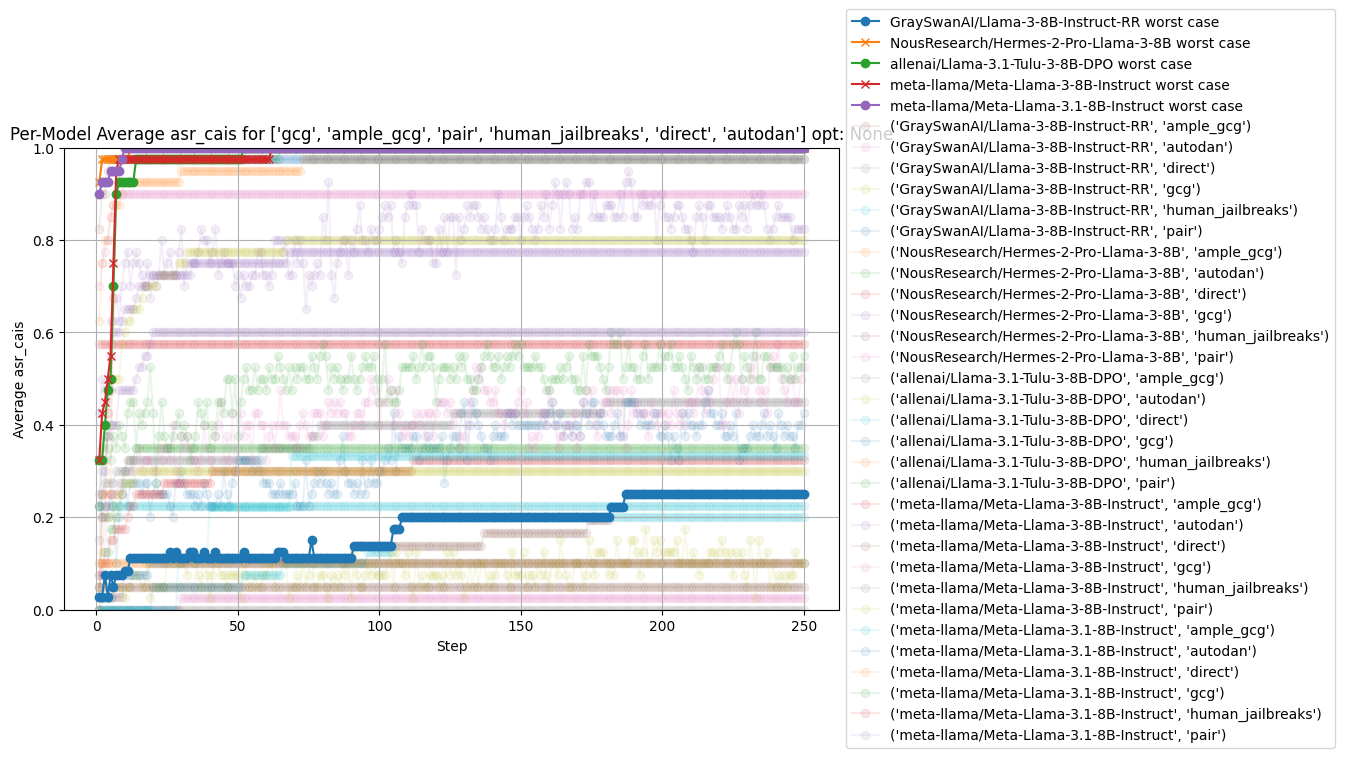

In [12]:
plot_attacks_per_model(target_df, algorithms=["gcg", "ample_gcg", "pair", "human_jailbreaks", "direct", "autodan"], metric="asr_cais")

Found 1447 pgd runs


Merging into 200 runs


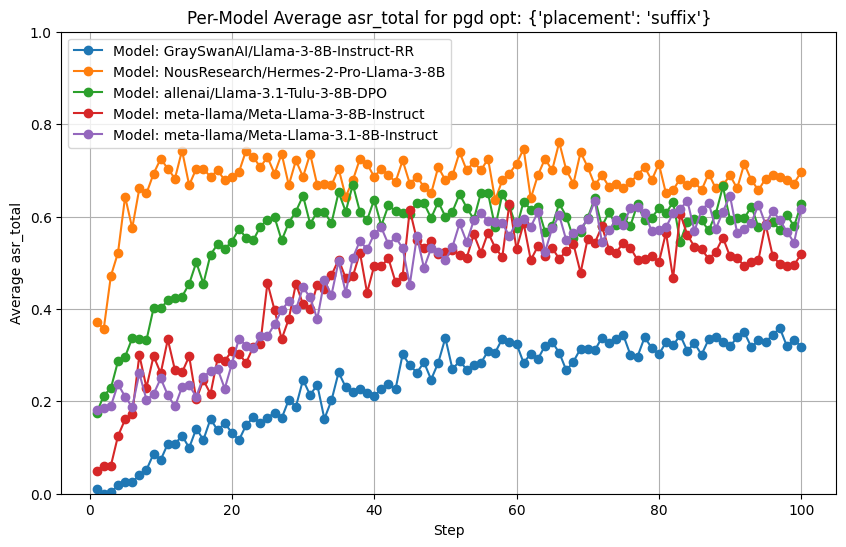

In [13]:
attack_df = plot_per_model_average_metric(target_df, algorithm="pgd", metric="asr_total", algorithm_params={"placement": "suffix"})

Found 42 pgd runs
Merging into 42 runs


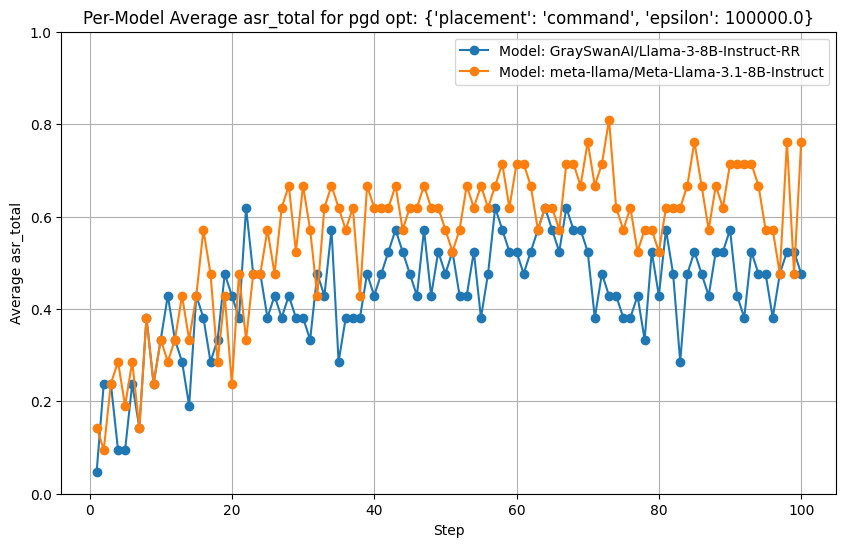

In [14]:
attack_df = plot_per_model_average_metric(target_df, algorithm="pgd", metric="asr_total", algorithm_params={"placement": "command", "epsilon": 100000.0})

# So far best constraint set

Found 200 pgd runs
Merging into 200 runs


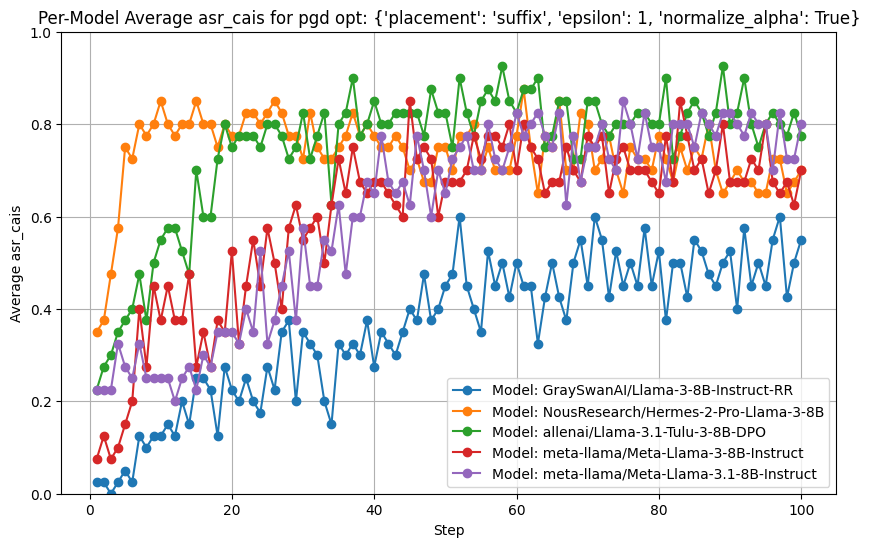

In [15]:
attack_df = plot_per_model_average_metric(target_df, algorithm="pgd", metric="asr_cais", algorithm_params={"placement": "suffix", "epsilon": 1, "normalize_alpha": True})

{'epsilon': 0.1, 'optim_str_init': '', 'placement': 'command', 'normalize_alpha': False}
Found 200 pgd runs
Merging into 200 runs


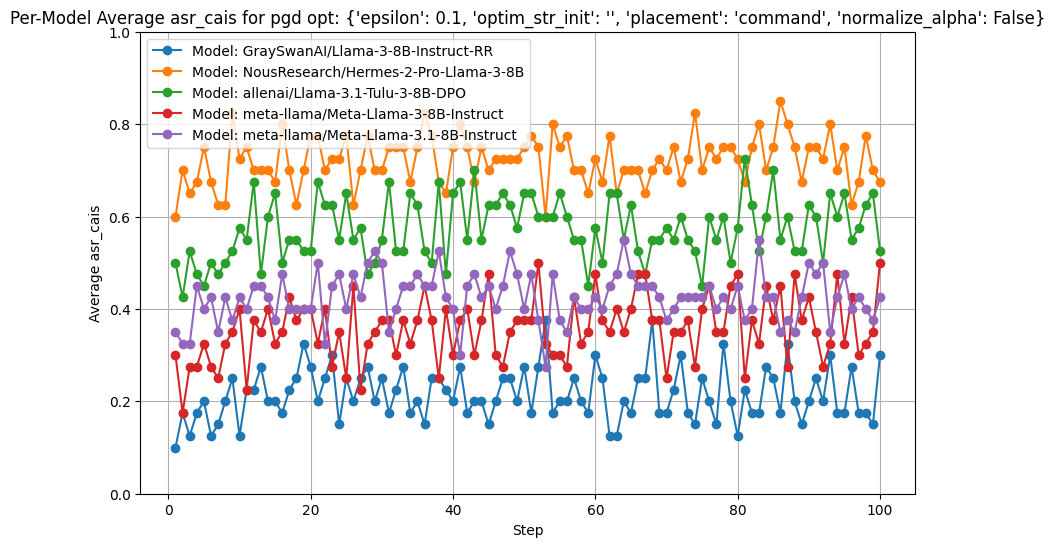

{'epsilon': 0.1, 'optim_str_init': '', 'placement': 'command', 'normalize_alpha': True}
Found 160 pgd runs
Merging into 160 runs


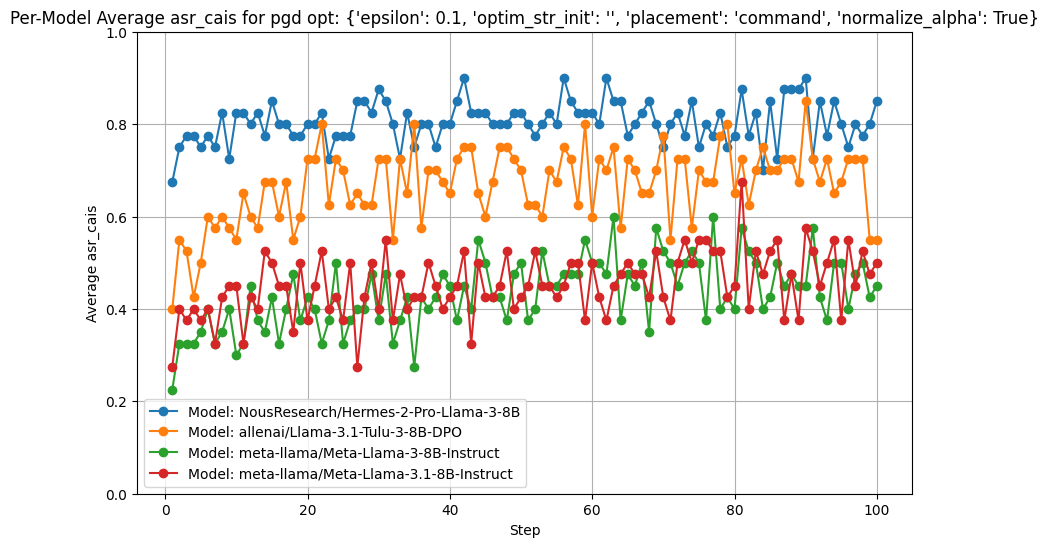

{'epsilon': 0.1, 'optim_str_init': 'x x x x x x x x x x x x x x x x x x x x', 'placement': 'suffix', 'normalize_alpha': False}
Found 230 pgd runs
Merging into 192 runs


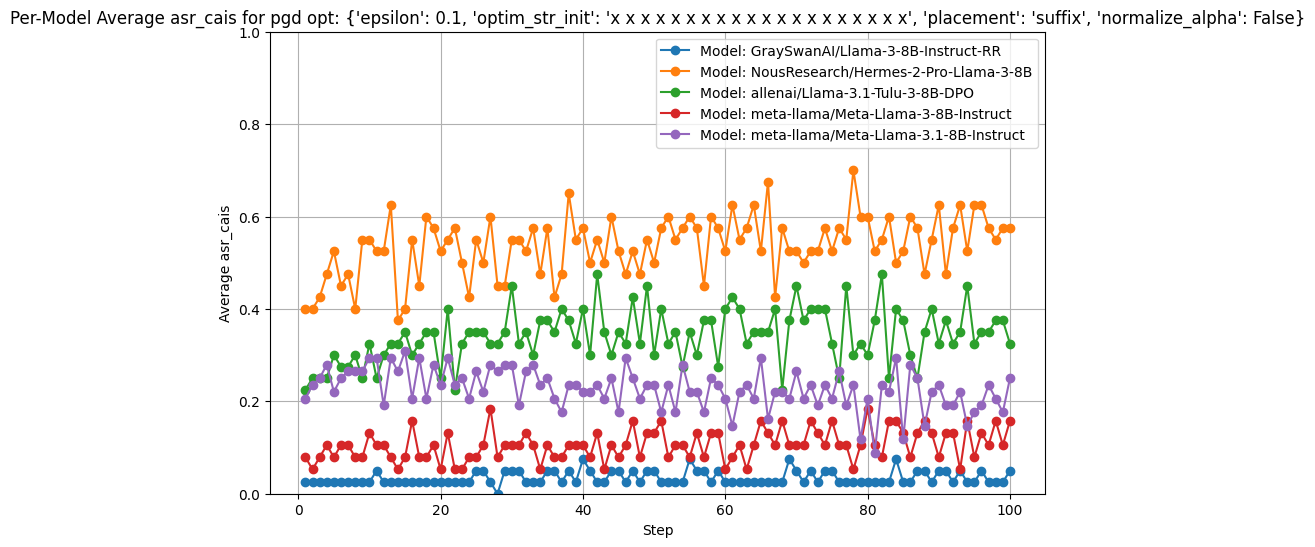

{'epsilon': 0.1, 'optim_str_init': 'x x x x x x x x x x x x x x x x x x x x', 'placement': 'suffix', 'normalize_alpha': True}
Found 195 pgd runs
Merging into 195 runs


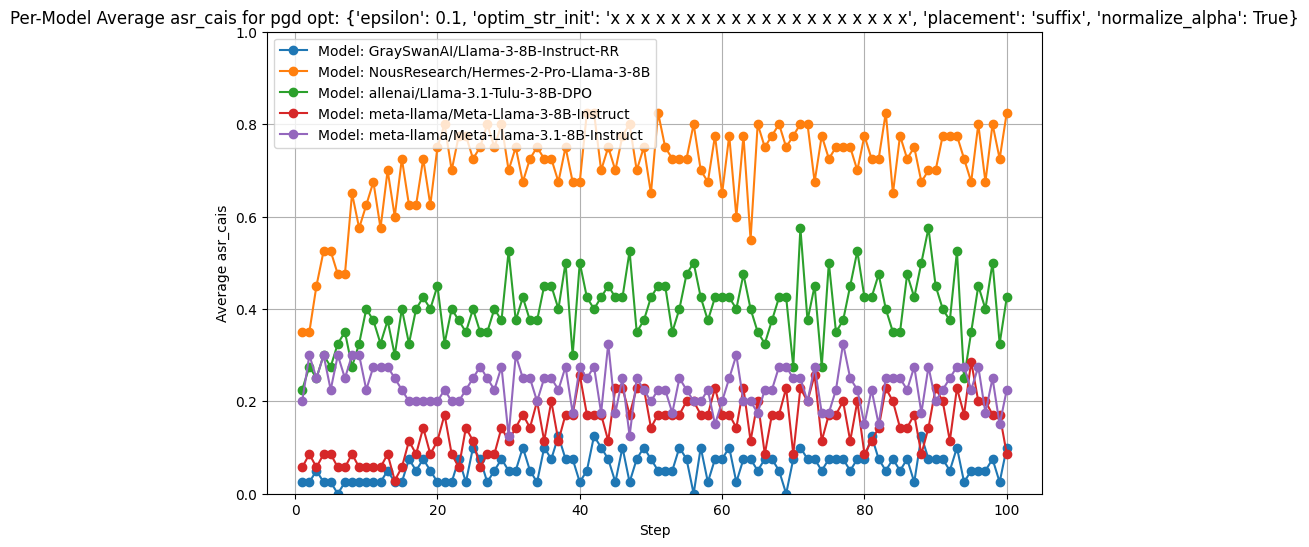

{'epsilon': 1, 'optim_str_init': '', 'placement': 'command', 'normalize_alpha': False}
Found 200 pgd runs
Merging into 200 runs


{'epsilon': 1, 'optim_str_init': '', 'placement': 'command', 'normalize_alpha': True}
Found 160 pgd runs
Merging into 160 runs


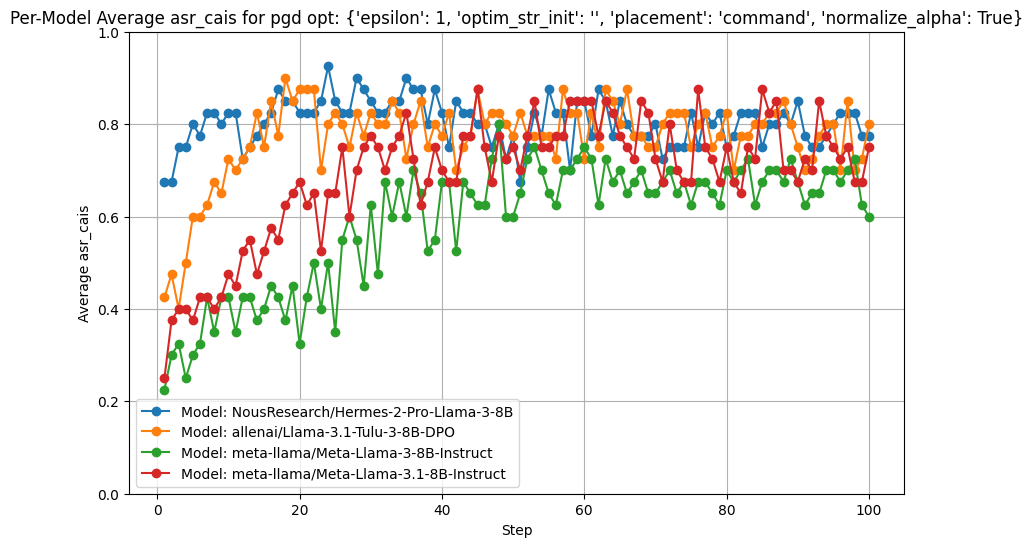

{'epsilon': 1, 'optim_str_init': 'x x x x x x x x x x x x x x x x x x x x', 'placement': 'suffix', 'normalize_alpha': False}
Found 233 pgd runs
Merging into 192 runs


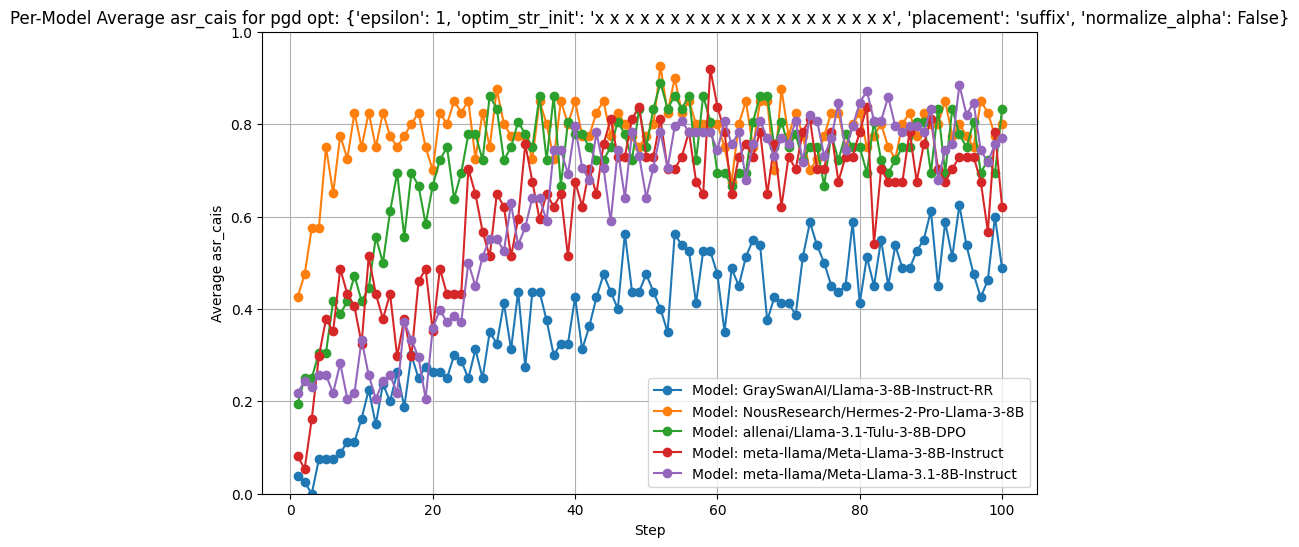

{'epsilon': 1, 'optim_str_init': 'x x x x x x x x x x x x x x x x x x x x', 'placement': 'suffix', 'normalize_alpha': True}
Found 200 pgd runs
Merging into 200 runs


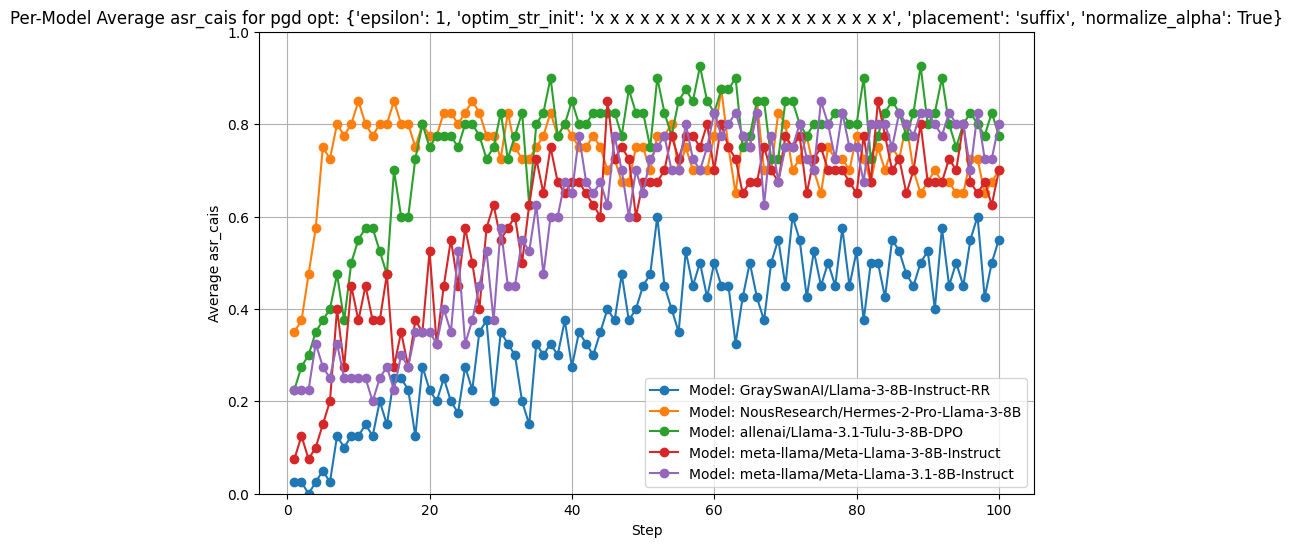

{'epsilon': 10, 'optim_str_init': '', 'placement': 'command', 'normalize_alpha': False}
Found 200 pgd runs
Merging into 200 runs


{'epsilon': 10, 'optim_str_init': '', 'placement': 'command', 'normalize_alpha': True}
Found 160 pgd runs
Merging into 160 runs


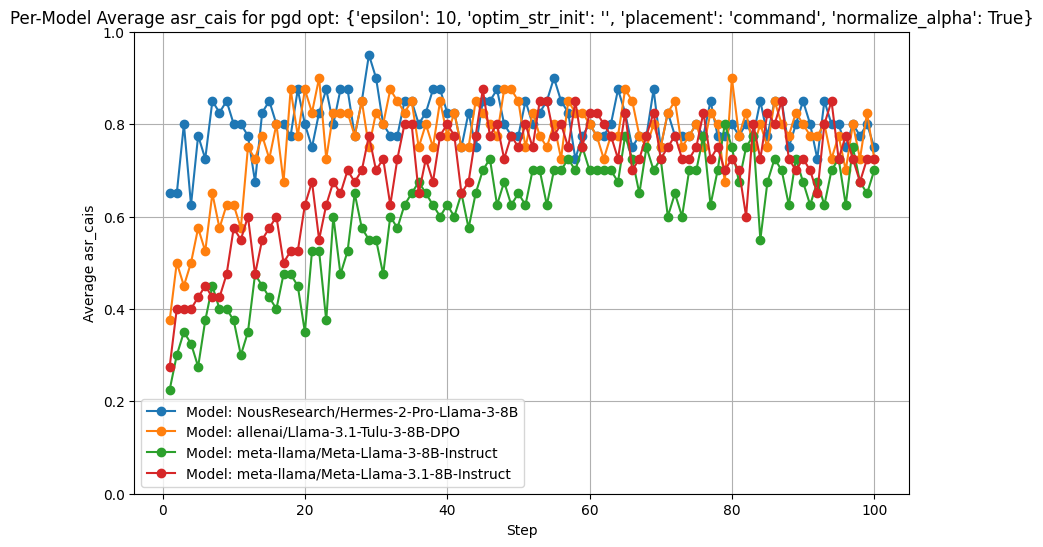

{'epsilon': 10, 'optim_str_init': 'x x x x x x x x x x x x x x x x x x x x', 'placement': 'suffix', 'normalize_alpha': False}
Found 191 pgd runs
Merging into 191 runs


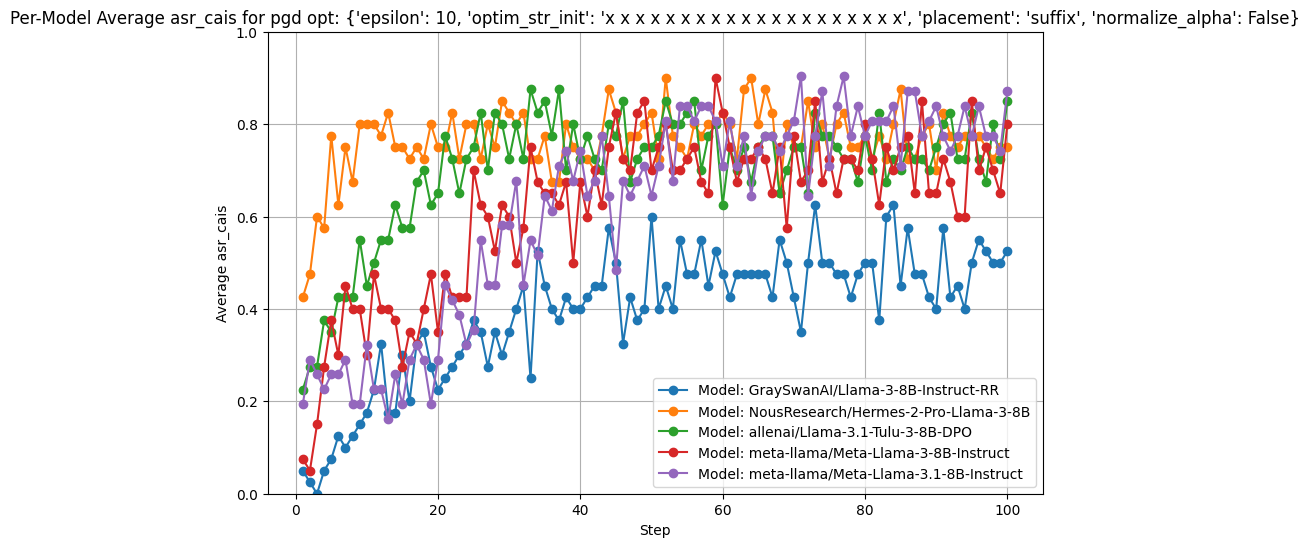

{'epsilon': 10, 'optim_str_init': 'x x x x x x x x x x x x x x x x x x x x', 'placement': 'suffix', 'normalize_alpha': True}
Found 200 pgd runs
Merging into 200 runs


{'epsilon': 100000.0, 'optim_str_init': '', 'placement': 'command', 'normalize_alpha': False}
Found 42 pgd runs
Merging into 42 runs


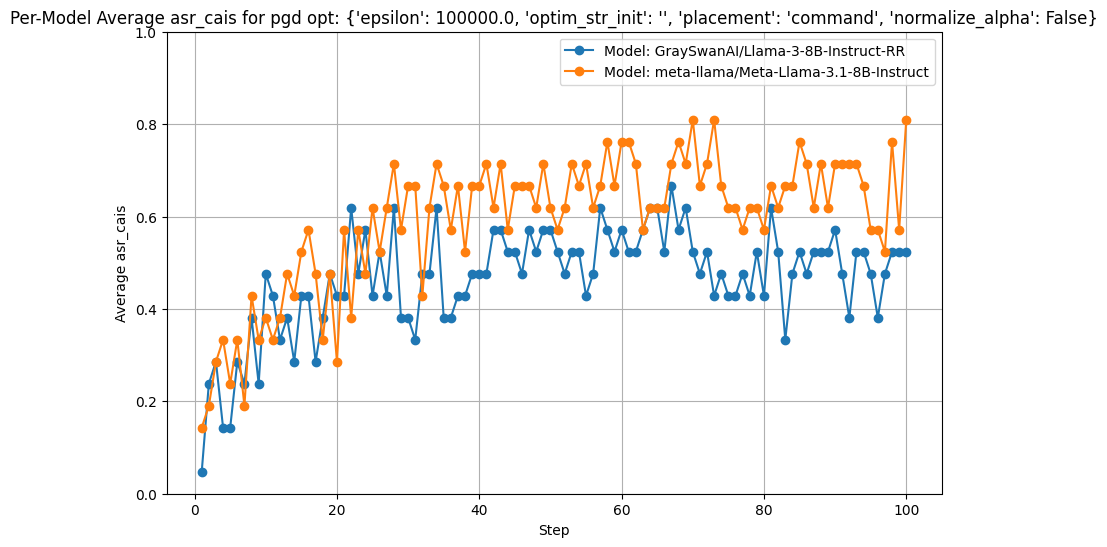

{'epsilon': 100000.0, 'optim_str_init': 'x x x x x x x x x x x x x x x x x x x x', 'placement': 'suffix', 'normalize_alpha': False}
Found 118 pgd runs
Merging into 80 runs


{'epsilon': 100000.0, 'optim_str_init': 'x x x x x x x x x x x x x x x x x x x x', 'placement': 'suffix', 'normalize_alpha': True}
Found 80 pgd runs
Merging into 80 runs


In [16]:
r = filter_runs(df, algorithm="pgd")
r = r[r['model'].isin(models)]
all_opts = [json.loads(e) for e in r["algorithm_params"].unique()]
for d in all_opts:
    if "normalize_alpha" not in d:
        d["normalize_alpha"] = False
all_opts = [{k: v for k, v in sorted(e.items()) if k != "embedding_scale"} for e in all_opts]
all_opts = set(json.dumps(e) for e in all_opts)
dicts = [json.loads(e) for e in all_opts]
# print(dicts)



# # Find all keys and their unique values across dictionaries
unique_values_per_key = defaultdict(set)
for d in dicts:
    for key, value in d.items():
        unique_values_per_key[key].add(value)

# Keep only keys with more than one unique value
keys_with_differences = {key for key, values in unique_values_per_key.items() if len(values) > 1}

# Filter dictionaries to include only differing keys
filtered_dicts = [{key: d[key] for key in keys_with_differences if key in d} for d in dicts]
filtered_dicts = sorted(filtered_dicts, key=lambda d: tuple(d.items()))

for d in filtered_dicts:
    print(d)
    plot_per_model_average_metric(target_df, algorithm="pgd", metric="asr_cais", algorithm_params=d)

In [17]:
algorithms = ["gcg", "pair", "ample_gcg", "direct", "human_jailbreaks", "autodan"]

In [18]:
plot_per_model_average_metric(target_df, algorithm="gcg", metric="asr_cais")
# should find 200 runs

Found 200 gcg runs
Merging into 200 runs
